In [1]:
# Code designed to measure the leakage current from an RC curve. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 

from tqdm import tqdm
import pickle

import swimAD2 as ad2
import time

####### End of importing #######


In [3]:
def voltage_cap(t,emf,tau):
    return emf*(1-np.exp(-t/tau))
def voltage_res(t,emf,tau):
    return emf*(np.exp(-t/tau))

def r_squared(f,xdata,ydata,*popt):
    residuals = ydata-f(xdata,*popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1 - (ss_res / ss_tot)

def minimise_err(t,v0,p0,type=0):
    # Type 0 is for resistor, 1, for capacitor. 
    tempo1,tempo2 = [],[]
    for i in range(len(t[:-1])):
        if type ==0:
            try: 
                qopt,_ = curve_fit(voltage_res,t[i:],v0[i:],p0 = p0,maxfev = 1800)
            except: break    
        else: 
            try:
                qopt,_ = curve_fit(voltage_cap,t[i:],v0[i:],p0 = p0,maxfev = 1800)
            except: break
        r2 = r_squared(voltage_res,t[i:],v0[i:],*qopt)
        tempo1.append(qopt),tempo2.append(r2)
    return tempo1[np.argmax(np.array(tempo2))]

### End of function defining ###

5it [00:00, 55.67it/s]


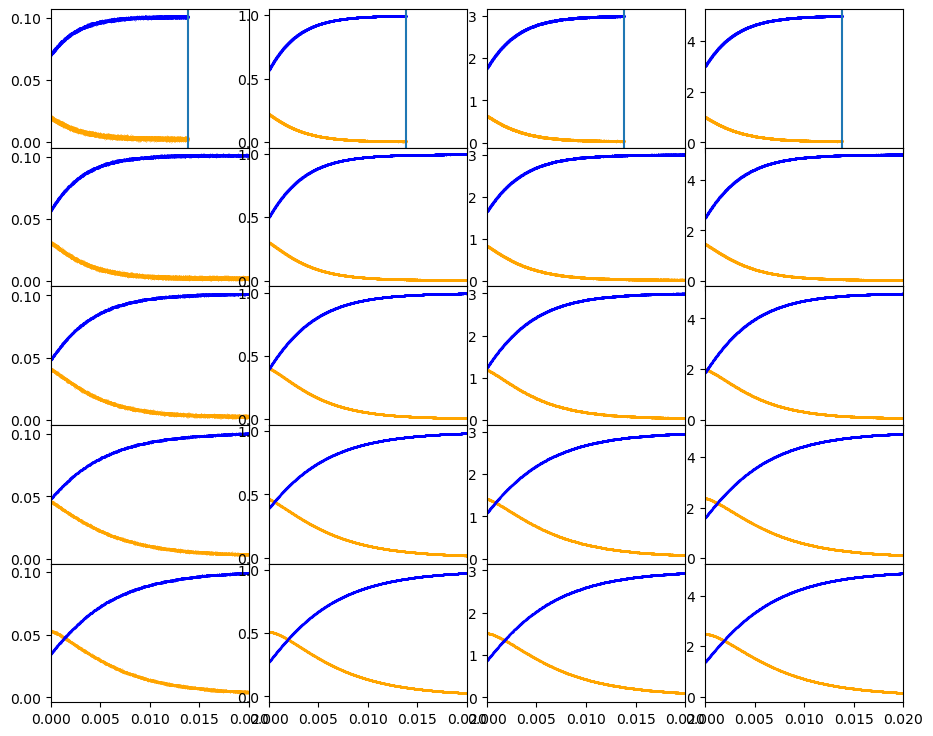

In [12]:
##### Start of actual code #####

handle = open("rc-leakage.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Res = data["res"] # Resistance in Ohms.
Cap = data["cap"] # Capacitance in Fahrads.
threshold = data["thresh"]

n_volt = [0.1,1,3,5]

fig, axes = plt.subplots(
                        len(Res),len(n_volt),
                        figsize=(11,9),sharex=True
                        )
fig.subplots_adjust(hspace=0,wspace=0.1)

for i,res in tqdm(enumerate(Res)):
    tau = res*Cap
    t_wait = -tau*np.log(threshold)
    ax = axes[i]
    for j,volt in enumerate(n_volt):
        t,v0,v1 = data[res][volt]["1th"]["rise"]
        ax[j].scatter(t,v0
                                , color="orange",s=0.05
                                , label="res"+str(volt)
                                )
        ax[j].scatter(t,v1
                                , color="blue",s=0.05
                                , label="cap"+str(volt)
                                )
            
        ax[j].axvline(x=t_wait)
        ax[j].set_xlim(0,0.02)
        # ax[j].legend(loc="lower right")


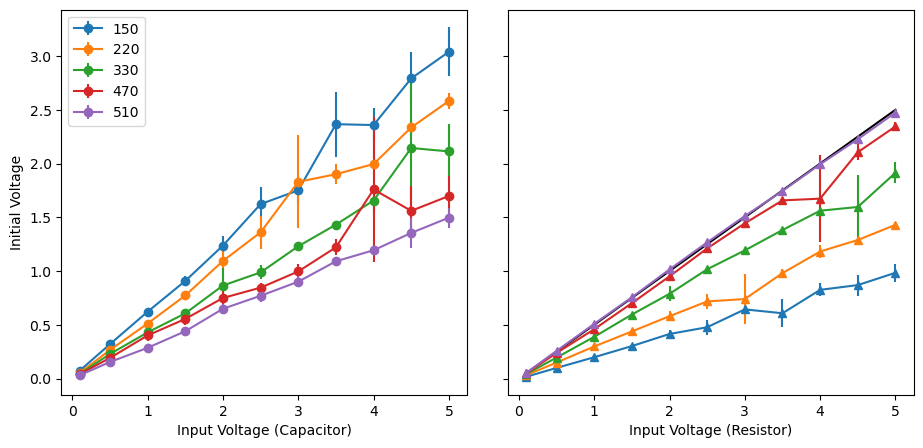

In [56]:
handle = open("rc-leakage.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Res = data["res"] # Resistance in Ohms.
Cap = data["cap"] # Capacitance in Fahrads.
threshold = data["thresh"]

n_volt = data[Res[0]].keys()
fig, axes = plt.subplots(
                        1,2,
                        figsize=(11,5),sharey=True
                        )

fig.subplots_adjust(hspace=0,wspace=0.1)


for res in Res:
    V_cap, V_res = [],[]
    C_err,R_err = [],[]
    for volt in n_volt:
        v_cap, v_res = [],[]
        for trial in data[res][volt].keys():
            t,v0,v1 = data[res][volt][trial]["rise"]
            v_res.append(v0[0]),v_cap.append(v1[0])
        V_res.append(np.mean(v_res)),V_cap.append(np.mean(v_cap))
        R_err.append(np.std(v_res)),C_err.append(np.std(v_cap))
    # Capacitor input vs initial 
    axes[0].errorbar(n_volt,V_cap
                     , yerr = C_err
                    # ,c=res,cmap="cividis"
                    # ,vmin = 100, vmax=600.
                     , marker="o"
                    # , color="red" ,ms=res/33
                     ,label=str(res))
    # Resistor input vs initial
    axes[1].errorbar(n_volt,V_res
                     , yerr = R_err
                    # ,c=res,cmap="cividis"
                    # ,vmin = 100,vmax=600.
                     , marker="^"
                    # , color="blue",ms=res/33
                     ,label="resistor")
axes[1].plot(n_volt,np.array(list(n_volt))/2,color="k")
axes[0].set_ylabel("Initial Voltage")
axes[0].set_xlabel("Input Voltage (Capacitor)")
axes[1].set_xlabel("Input Voltage (Resistor)")
axes[0].legend(loc="upper left")
# cbar = fig.colorbar(im,ax = axes.ravel().tolist())




In [ ]:
fig,axes = plt.subplots(
                        len(Res),len(n_volt),
                        figsize=(7,7),sharex=True,sharey=True
                        )
for i,res in Res:
    tau = res*Cap
    t_wait = -tau*np.log(threshold)
    ax = axes[i]
    for j,volt in tqdm(enumerate(n_volt)):
        t,v0,v1 = data[res][volt]["1th"]["rise"]
        ax[j].scatter(t,v0
                                , color="orange",s=0.3
                                # , label="res"+str(volt)
                                )
        ax[j].scatter(t,v1
                                , color="blue",s=0.3
                                # , label="cap"+str(volt)
                                )
            
        popt = minimise_err(t,v1,p0=[volt,tau],type=1)
        qopt = minimise_err(t,v0,p0=[volt,tau],type=0)

        ax[j].plot(t,voltage_cap(t,*popt),
                        label="Cap fit"
                        )
        ax[j].plot(t,voltage_res(t,*qopt),
                        color="red",label="Res fit"
                        )
        ax[j].axvline(x=t_wait)
        ax[j].set_xlim(0,0.02)
        ax[j].legend(loc="lower right")
